In [78]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import sklearn.metrics as skm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score as aps
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve

In [2]:
df=pd.read_excel("Euro2020new.xlsx")
Match_data=pd.read_excel('Match_data.xlsx')

In [ ]:
##creating function that will calculate result of game
def result(cols):
    homescore=cols[0]
    awayscore=cols[1]
    
    if homescore>awayscore:
        return 'win'
    elif homescore<awayscore:
        return 'loss'
    elif homescore==awayscore:
        return'draw'

In [ ]:
def result1(cols):
    outcome=cols
    
    
    if outcome=='win':
        return '1'
    elif outcome=='loss':
        return '2'
    elif outcome=='draw':
        return '0'

In [ ]:
Match_data['Date']=pd.to_datetime(Match_data['Date'])## adding column with year
Match_data['Year']=Match_data['Date'].apply(lambda time: time.year)
#Dropping old Date column
Match_data.drop('Date',inplace=True,axis=1)

In [16]:
for i in range(len(df)):# calculating goals for/against, Wins/losses in previous year
    if df['Year'].iloc[i]>=2008:
        team=df['Team'].iloc[i]
        year=df['Year'].iloc[i]
      
        goalsf=df['Goals For'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['Goals For']
        goalsa=df['Goals Against'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['Goals Against']
        Wins=df['W'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['W']
        Losses=df['L'].iloc[i]- df[(df['Team']==team) & (df['Year']==year-1)]['L']
        if not df[(df['Team']==team) & (df['Year']==year-1)]['Team'].empty:
            df.loc[i,'1_Year_change-goals']=goalsf.values
            df.loc[i,'1_Year_change-goalsa']=goalsa.values
            df.loc[i,'1_Year_change-W']=Wins.values
            df.loc[i,'1_Year_change-L']=Losses.values

In [10]:
df['Win/loss ratio']=df[['1_Year_change-W','1_Year_change-L']].apply(lambda x: x['1_Year_change-W']/(x['1_Year_change-W']+x['1_Year_change-L']),axis=1)

C:\Users\mkepa\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [22]:
df['Goals Difference']=df[['1_Year_change-goals','1_Year_change-goalsa']].apply(lambda x: x['1_Year_change-goals']-x['1_Year_change-goalsa'],axis=1)

In [27]:
df.drop(df[df.Year==2007].index,inplace=True)

In [30]:
df.reset_index(drop=True, inplace=True)

In [16]:
##changing Country names to match ELO rating file
Match_data['Home_Team']=Match_data['Home_Team'].replace(['Czech Republic','North. Ireland','Rep. of Ireland','Bosnia & Herzegovina','U.A.E.','C?te d`Ivoire','Trinidad & Tobago'],
                                ['Czechia','Northern Ireland','Ireland','Bosnia and Herzegovina','United Arab Emirates','Ivory Coast','Trinidad and Tobago'])

Match_data['Away_Team']=Match_data['Away_Team'].replace(['Czech Republic','North. Ireland','Rep. of Ireland','Bosnia & Herzegovina','U.A.E.','C?te d`Ivoire','Trinidad & Tobago','Romana','Rep. Of Ireland'],
                                ['Czechia','Northern Ireland','Ireland','Bosnia and Herzegovina','United Arab Emirates','Ivory Coast','Trinidad and Tobago','Romania','Ireland'])

In [85]:
for i in range(len(Match_data)):## Adding ELO rating,1_Year_change-goals,1_Year_change-goalsa,Goals Difference,Win/loss ratio to match data
    home=Match_data['Home_Team'].iloc[i]
    away=Match_data['Away_Team'].iloc[i]
    year=Match_data['Year'].iloc[i]
    
    homeR=df[(df['Team']==home) & (df['Year']==year)]['R']
    awayR=df[(df['Team']==away) & (df['Year']==year)]['R']
    homeg=df[(df['Team']==home) & (df['Year']==year)]['1_Year_change-goals']
    awayg=df[(df['Team']==away) & (df['Year']==year)]['1_Year_change-goals']
    homelg=df[(df['Team']==home) & (df['Year']==year)]['1_Year_change-goalsa']
    awaylg=df[(df['Team']==away) & (df['Year']==year)]['1_Year_change-goalsa']
    goalsdiffhome=df[(df['Team']==home) & (df['Year']==year)]['Goals Difference']
    goalsdiffaway=df[(df['Team']==away) & (df['Year']==year)]['Goals Difference']
    winlosth=df[(df['Team']==home) & (df['Year']==year)]['Win/loss ratio']
    winlosta=df[(df['Team']==away) & (df['Year']==year)]['Win/loss ratio']

    
    Match_data.loc[i,'Home_Elo rating']=homeR.values
    Match_data.loc[i,'Away_Elo rating']=awayR.values
    Match_data.loc[i,'1_Year_change-goals-home']=homeg.values
    Match_data.loc[i,'1_Year_change-goals-away']=awayg.values
    Match_data.loc[i,'1_Year_change-lost_goals-home']=homelg.values
    Match_data.loc[i,'1_Year_change-lost_goals-away']=awaylg.values
    Match_data.loc[i,'Goals_diff_home']=goalsdiffhome.values
    Match_data.loc[i,'Goals_diff_away']=goalsdiffaway.values
    Match_data.loc[i,'Win/loss ratio-home_team']=winlosth.values
    Match_data.loc[i,'Win/loss ratio-away_team']=winlosta.values
   

In [32]:
gdp=pd.read_excel('GDP.xlsx')

In [88]:
for i in range(len(Match_data)):## Adding GDP  to match data
    
    home=Match_data['Home_Team'].iloc[i]
    away=Match_data['Away_Team'].iloc[i]
    year=str(Match_data['Year'].iloc[i])
    homeGDP=gdp[gdp['Country Name']==home][year]
    awayGDP=gdp[gdp['Country Name']==away][year]
    if not gdp[gdp['Country Name']==home][year].empty:
        Match_data.loc[i,'Home_GDP']=homeGDP.values
       
    if not gdp[gdp['Country Name']==away][year].empty:
        Match_data.loc[i,'Away_GDP']=awayGDP.values
        
    

In [4]:
Match_data['Home_GDP'].isna().sum()/Match_data.shape[0]*100 ##percantege of nill values in Home GDP

4.39297124600639

In [17]:
Match_data['Home_GDP']=Match_data['Home_GDP'].fillna(Match_data['Home_GDP'].mean())##filling nill GDP with mean
Match_data['Away_GDP']=Match_data['Away_GDP'].fillna(Match_data['Away_GDP'].mean())

In [6]:
Match_data['Home_GDP'].isna().sum()

0

In [55]:
##adding win/loss/draw based on result
Match_data['Result']=Match_data[['Home_score','Away_Score']].apply(result,axis=1)

In [591]:
###adding 1-win team A,0-draw,2-win team B 
Match_data['Y']=Match_data['Result'].apply(result1)


In [11]:

### Creating Exogenous variables data frame#
X=Match_data[['FIFA_Points_Home','FIFA_Points_Away','Home_Elo rating','Away_Elo rating','1_Year_change-wins_home','1_Year_change-wins_away','1_Year_change-loss_home','1_Year_change-loss_away','1_Year_change-goals-home','1_Year_change-goals-away','1_Year_change-lost_goals-home','1_Year_change-lost_goals-away']]

In [57]:
##Creating endogenous variable

y=Match_data['Y']



In [14]:
## Normalizing FIFA and ELO rating points
X_to_normalize=X[['FIFA_Points_Home','FIFA_Points_Away','Home_Elo rating','Away_Elo rating']]
X_without_normalize=X[['1_Year_change-wins_home','1_Year_change-wins_away','1_Year_change-loss_home','1_Year_change-loss_away','1_Year_change-goals-home','1_Year_change-goals-away','1_Year_change-lost_goals-home','1_Year_change-lost_goals-away']]
scale=MinMaxScaler()
X_norm=pd.DataFrame(scale.fit_transform(X_to_normalize),

columns=X_to_normalize.columns, index=X_to_normalize.index)

X=pd.concat([X_norm,X_without_normalize],axis=1)

In [6]:
## creating model to check which variables are irrelevant
model = sm.Logit(y, X)

In [7]:
result = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.527708
         Iterations 6


In [8]:
result.params

FIFA_Points_Home                 1.430091e+00
FIFA_Points_Away                -1.924771e+00
Home_Elo rating                  4.962254e+00
Away_Elo rating                 -4.753621e+00
1_Year_change-wins_home         -2.234374e-02
1_Year_change-wins_away          1.718170e-01
1_Year_change-loss_home          5.703322e-02
1_Year_change-loss_away         -8.860534e-02
1_Year_change-goals-home         6.874655e-03
1_Year_change-goals-away        -3.555396e-02
1_Year_change-lost_goals-home   -1.536496e-02
1_Year_change-lost_goals-away    2.667595e-02
Home_GDP                         1.014396e-06
Away_GDP                         8.336302e-07
Win/loss ratio-home_team        -1.705659e-01
Win/loss ratio-away_team        -9.351992e-01
dtype: float64

In [9]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Result4   No. Observations:                 2496
Model:                          Logit   Df Residuals:                     2480
Method:                           MLE   Df Model:                           15
Date:                Sun, 13 Jun 2021   Pseudo R-squ.:                  0.2311
Time:                        14:34:30   Log-Likelihood:                -1317.2
converged:                       True   LL-Null:                       -1713.0
Covariance Type:            nonrobust   LLR p-value:                5.218e-159
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
FIFA_Points_Home                  1.4301      0.365      3.919      0.000       0.715       2.145
FIFA_Points_Away                 -1.9248      0.370     -5.198      0.000      -2.651      -1.199
Home_Elo rating                   4.9623      0.611      8.127      0.000       3.765       6.159
Away_Elo rating                  -4.7536      0.616     -7.715      0.000      -5.961      -3.546
1_Year_change-wins_home          -0.0223      0.048     -0.466      0.642      -0.116       0.072
1_Year_change-wins_away           0.1718      0.050      3.449      0.001       0.074       0.269
1_Year_change-loss_home           0.0570      0.056      1.012      0.312      -0.053       0.168
1_Year_change-loss_away          -0.0886      0.059     -1.514      0.130      -0.203       0.026
1_Year_change-goals-home          0.0069      0.014      0.479      0.632      -0.021       0.035
1_Year_change-goals-away         -0.0356      0.015     -2.336      0.019      -0.065      -0.006
1_Year_change-lost_goals-home    -0.0154      0.017     -0.909      0.363      -0.048       0.018
1_Year_change-lost_goals-away     0.0267      0.018      1.521      0.128      -0.008       0.061
Home_GDP                       1.014e-06   1.94e-06      0.522      0.601   -2.79e-06    4.82e-06
Away_GDP                       8.336e-07   1.91e-06      0.437      0.662    -2.9e-06    4.57e-06
Win/loss ratio-home_team         -0.1706      0.578     -0.295      0.768      -1.304       0.963
Win/loss ratio-away_team         -0.9352      0.587     -1.592      0.111      -2.087       0.216
=================================================================================================
"""

In [15]:
## creating function that evaluates optimal l2 penalty value
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        
        key = '%.4f' % p
      
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    return models

In [16]:
models = get_models()
results, names = list(), list()

def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>0.0000 0.591 (0.023)
>0.0001 0.545 (0.027)
>0.0010 0.547 (0.028)
>0.0100 0.559 (0.029)
>0.1000 0.585 (0.019)
>1.0000 0.589 (0.022)


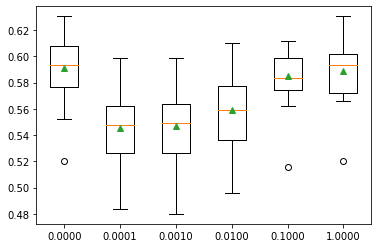

In [17]:
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()
#Below charts shows that best solution for model will be not using L2 penalty at all.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model=LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none',max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
predictions=model.predict(X_test)

In [62]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.03      0.06       163
           1       0.63      0.82      0.71       325
           2       0.61      0.74      0.67       261

    accuracy                           0.62       749
   macro avg       0.69      0.53      0.48       749
weighted avg       0.67      0.62      0.55       749



In [63]:
confusion_matrix(y_test,predictions)## rows are actual values, columns predicted

array([[  5,  90,  68],
       [  1, 267,  57],
       [  0,  68, 193]], dtype=int64)

In [64]:
model.score(X_train,y_train)

0.5809959931310819

In [124]:
logr_probs=model.predict_proba(X_test)

In [125]:
logr_probs0 = lr_probs[:,0]
logr_probs1=lr_probs[:,1]
logr_probs2=lr_probs[:,2]

In [126]:
precision0, recall0, _ = skm.precision_recall_curve(y_test,logr_probs0,pos_label=0)
precision1, recall1, _ = skm.precision_recall_curve(y_test,logr_probs1,pos_label=1)
precision2, recall2, _ = skm.precision_recall_curve(y_test,logr_probs2,pos_label=2)

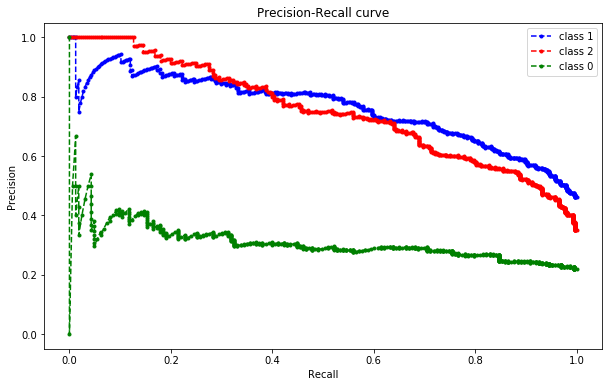

In [127]:
plt.figure(figsize=(10,6))
plt.plot(recall1, precision1,'b', label='class 1',linestyle='--',marker='.')
plt.plot(recall2, precision2,'r', label='class 2',linestyle='--',marker='.')
plt.plot(recall0, precision0,'g', label='class 0',linestyle='--',marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title("Precision-Recall curve")
plt.show()

In [128]:
logr_fpr1, logr_tpr1, _ = roc_curve(y_test, logr_probs1,pos_label=1)
logr_fpr2, logr_tpr2, _ = roc_curve(y_test, logr_probs2,pos_label=2)
logr_fpr0, logr_tpr0, _ = roc_curve(y_test, logr_probs2,pos_label=0)

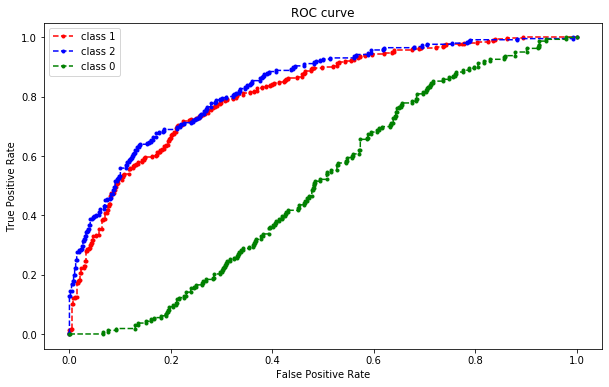

In [129]:
plt.figure(figsize=(10,6))
plt.plot(logr_fpr1, logr_tpr1,'r', label='class 1',linestyle='--',marker='.')
plt.plot(logr_fpr2, logr_tpr2,'b', label='class 2',linestyle='--',marker='.')
plt.plot(logr_fpr0, logr_tpr0,'g', label='class 0',linestyle='--',marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title("ROC curve")
plt.show()

In [130]:
logr_auc0=auc(recall0, precision0)
logr_auc1=auc(recall1, precision1)
logr_auc2=auc(recall2, precision2)
print('AUC-label 0:',lr_auc0,'\n','AUC-label 1:',lr_auc1,'\n','AUC-label 1:',lr_auc2)

AUC-label 0: 0.3057983748136651 
 AUC-label 1: 0.7612392243803298 
 AUC-label 1: 0.7510054575547354


In [114]:
## predicting Euro 2020 games results
data_to_predict1=pd.read_excel("data_to_predict1.xlsx")

In [115]:
predict_data_normalize=data_to_predict1[['FIFA_Points_Home','FIFA_Points_Away','Home_Elo rating','Away_Elo rating']]
predict_data_without_normalize=data_to_predict1[['1_Year_change-wins_home','1_Year_change-wins_away','1_Year_change-loss_home','1_Year_change-loss_away','1_Year_change-goals-home','1_Year_change-goals-away','1_Year_change-lost_goals-home','1_Year_change-lost_goals-away']]

In [116]:
X_norm=pd.DataFrame(scale.fit_transform(predict_data_normalize),

columns=predict_data_normalize.columns, index=predict_data_normalize.index)

In [117]:
X_to_predict=pd.concat([X_norm,predict_data_without_normalize],axis=1)

In [118]:
X_to_predict.head()

,FIFA_Points_Home,FIFA_Points_Away,Home_Elo rating,Away_Elo rating,1_Year_change-wins_home,1_Year_change-wins_away,1_Year_change-loss_home,1_Year_change-loss_away,1_Year_change-goals-home,1_Year_change-goals-away,1_Year_change-lost_goals-home,1_Year_change-lost_goals-away
0,0.320293,0.655257,0.339483,0.791513,1,5,2,0,12,17,14,2
1,0.479218,0.567237,0.479705,0.557196,5,0,1,4,7,8,4,12
2,0.628362,0.088020,0.660517,0.258303,5,5,2,3,14,10,7,10
3,1.000000,0.215159,1.000000,0.321033,6,2,1,3,19,10,8,14
4,0.762836,0.564792,0.725092,0.536900,5,2,2,5,13,14,4,20


In [119]:
predictions=model.predict_proba(X_to_predict)

In [120]:
Euro_predictions=pd.DataFrame(data=predictions, columns=['draw%','Team1-win%','Team2-win%']).round(decimals=3)

In [121]:
Euro_predictions=Euro_predictions.apply(lambda x: x*100)

In [123]:
Euro_predictions.to_excel('Euro_predictions1.xlsx')